# CE-Net


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
import json
import h5py
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from functools import partial


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
nonlinearity = partial(F.relu, inplace=True)

In [5]:
class DACblock(nn.Module):
    def __init__(self, channel):
        super(DACblock, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=3, padding=3)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=5, padding=5)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out


class DACblock_without_atrous(nn.Module):
    def __init__(self, channel):
        super(DACblock_without_atrous, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate2 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.conv1x1(self.dilate2(x)))
        dilate3_out = nonlinearity(self.conv1x1(self.dilate2(self.dilate1(x))))
        dilate4_out = nonlinearity(self.conv1x1(self.dilate3(self.dilate2(self.dilate1(x)))))
        out = x + dilate1_out + dilate2_out + dilate3_out + dilate4_out

        return out

class DACblock_with_inception(nn.Module):
    def __init__(self, channel):
        super(DACblock_with_inception, self).__init__()
        self.dilate1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)

        self.dilate3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv1x1 = nn.Conv2d(2 * channel, channel, kernel_size=1, dilation=1, padding=0)
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.dilate1(x))
        dilate2_out = nonlinearity(self.dilate3(self.dilate1(x)))
        dilate_concat = nonlinearity(self.conv1x1(torch.cat([dilate1_out, dilate2_out], 1)))
        dilate3_out = nonlinearity(self.dilate1(dilate_concat))
        out = x + dilate3_out
        return out


class DACblock_with_inception_blocks(nn.Module):
    def __init__(self, channel):
        super(DACblock_with_inception_blocks, self).__init__()
        self.conv1x1 = nn.Conv2d(channel, channel, kernel_size=1, dilation=1, padding=0)
        self.conv3x3 = nn.Conv2d(channel, channel, kernel_size=3, dilation=1, padding=1)
        self.conv5x5 = nn.Conv2d(channel, channel, kernel_size=5, dilation=1, padding=2)
        self.pooling = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        dilate1_out = nonlinearity(self.conv1x1(x))
        dilate2_out = nonlinearity(self.conv3x3(self.conv1x1(x)))
        dilate3_out = nonlinearity(self.conv5x5(self.conv1x1(x)))
        dilate4_out = self.pooling(x)
        out = dilate1_out + dilate2_out + dilate3_out + dilate4_out
        return out



class PSPModule(nn.Module):
    def __init__(self, features, out_features=1024, sizes=(2, 3, 6, 14)):
        super().__init__()
        self.stages = []
        self.stages = nn.ModuleList([self._make_stage(features, size) for size in sizes])
        self.bottleneck = nn.Conv2d(features * (len(sizes) + 1), out_features, kernel_size=1)
        self.relu = nn.ReLU()

    def _make_stage(self, features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, features, kernel_size=1, bias=False)
        return nn.Sequential(prior, conv)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.upsample(input=stage(feats), size=(h, w), mode='bilinear') for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return self.relu(bottle)


class SPPblock(nn.Module):
    def __init__(self, in_channels):
        super(SPPblock, self).__init__()
        self.pool1 = nn.MaxPool2d(kernel_size=[2, 2], stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=[3, 3], stride=3)
        self.pool3 = nn.MaxPool2d(kernel_size=[5, 5], stride=5)
        #self.pool4 = nn.MaxPool2d(kernel_size=[6, 6], stride=6)

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=1, kernel_size=1, padding=0)

    def forward(self, x):
        self.in_channels, h, w = x.size(1), x.size(2), x.size(3)
        self.layer1 = F.upsample(self.conv(self.pool1(x)), size=(h, w), mode='bilinear')
        self.layer2 = F.upsample(self.conv(self.pool2(x)), size=(h, w), mode='bilinear')
        self.layer3 = F.upsample(self.conv(self.pool3(x)), size=(h, w), mode='bilinear')
        #self.layer4 = F.upsample(self.conv(self.pool4(x)), size=(h, w), mode='bilinear')

        out = torch.cat([self.layer1, self.layer2, self.layer3, x], 1)

        return out


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, n_filters):
        super(DecoderBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, in_channels // 4, 1)
        self.norm1 = nn.BatchNorm2d(in_channels // 4)
        self.relu1 = nonlinearity

        self.deconv2 = nn.ConvTranspose2d(in_channels // 4, in_channels // 4, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(in_channels // 4)
        self.relu2 = nonlinearity

        self.conv3 = nn.Conv2d(in_channels // 4, n_filters, 1)
        self.norm3 = nn.BatchNorm2d(n_filters)
        self.relu3 = nonlinearity

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.deconv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = self.relu3(x)

        return x

In [6]:
class CE_Net_(nn.Module):
    def __init__(self, num_channels=4, num_classes=5):
        super(CE_Net_, self).__init__()

        filters = [64,128,256,(512+3)]
        resnet = models.resnet34(pretrained=True)
        self.firstconv = nn.Conv2d(num_channels, 64, 7, padding=3)
        self.firstbn = resnet.bn1
        self.firstrelu = resnet.relu
        self.firstmaxpool = resnet.maxpool
        self.encoder1 = resnet.layer1
        self.encoder2 = resnet.layer2
        self.encoder3 = resnet.layer3
        self.encoder4 = resnet.layer4

        self.dblock = DACblock(512)
        self.spp = SPPblock(512)

        self.decoder4 = DecoderBlock(filters[3], filters[2])
        self.decoder3 = DecoderBlock(filters[2], filters[1])
        self.decoder2 = DecoderBlock(filters[1], filters[0])
        self.decoder1 = DecoderBlock(filters[0], filters[0])

        self.finaldeconv1 = nn.ConvTranspose2d(filters[1], 32, 4, 2, 1)
        self.finalrelu1 = nonlinearity
        self.finalconv2 = nn.Conv2d(32, 32, 10, padding=1)
        self.finalrelu2 = nonlinearity
        self.finalconv3 = nn.Conv2d(32, num_classes, 3, padding=1)

    def forward(self, x):
        # Encoder
        x = self.firstconv(x)
        x = self.firstbn(x)
        x = self.firstrelu(x)
        x = self.firstmaxpool(x)
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)

        # Center
        e4 = self.dblock(e4)
        e4 = F.upsample(e4,size=(5,5),mode='bilinear')
        e4 = self.spp(e4)

        # Decoder
        d4 = self.decoder4(e4) + F.upsample(e3,size=(10,10),mode='bilinear')
        d3 = self.decoder3(d4) + F.upsample(e2,size=(20,20),mode='bilinear')#e2
        #d2 = self.decoder2(d3) + F.upsample(e1,size=(40,40),mode='bilinear')#e1
        #d1 = self.decoder1(d2)

        out = self.finaldeconv1(d3)
        out = self.finalrelu1(out)
        out = self.finalconv2(out)
        out = self.finalrelu2(out)
        out = self.finalconv3(out)

        return out

In [7]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [8]:

train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [9]:
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))


In [10]:
# Create Model object from the class defined above. Input channels = 4, output channels = 5
net = CE_Net_(num_channels=4, num_classes=5).to(device,dtype=torch.float32)
net.to(device) 
# if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

CE_Net_(
  (firstconv): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (firstbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (firstrelu): ReLU(inplace=True)
  (firstmaxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace

In [11]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_2'):
    os.mkdir('Model_2')
model_save_path = 'Model_2/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

[                                                                        ]N/A% 

Starting epoch 1/100.


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.0000 --- loss: 1.640169


[*************                                                           ] 19% 

0.2000 --- loss: 1.444052


[****************************                                            ] 39% 

0.4000 --- loss: 1.251938


[******************************************                              ] 59% 

0.6000 --- loss: 1.301355


[*********************************************************               ] 79% 

0.8000 --- loss: 1.259998


[***                                                                     ]  4% 

Epoch finished ! Loss: 1.3676691055297852


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 1.1946864128112793
Checkpoint 1 saved !
Starting epoch 2/100.
0.0000 --- loss: 1.208227


[*************                                                           ] 19% 

0.2000 --- loss: 1.198864


[****************************                                            ] 39% 

0.4000 --- loss: 1.187297


[******************************************                              ] 59% 

0.6000 --- loss: 1.083882


[*********************************************************               ] 79% 

0.8000 --- loss: 1.164726


[***                                                                     ]  4% 

Epoch finished ! Loss: 1.1802895069122314


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 1.027440071105957
Checkpoint 2 saved !
Starting epoch 3/100.
0.0000 --- loss: 1.171089


[*************                                                           ] 19% 

0.2000 --- loss: 1.029828


[****************************                                            ] 39% 

0.4000 --- loss: 0.950133


[******************************************                              ] 59% 

0.6000 --- loss: 0.988580


[*********************************************************               ] 79% 

0.8000 --- loss: 0.956754


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.9703308939933777


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.8672777414321899
Checkpoint 3 saved !
Starting epoch 4/100.
0.0000 --- loss: 0.923657


[*************                                                           ] 19% 

0.2000 --- loss: 0.999338


[****************************                                            ] 39% 

0.4000 --- loss: 0.806752


[******************************************                              ] 59% 

0.6000 --- loss: 0.800803


[*********************************************************               ] 79% 

0.8000 --- loss: 0.862924


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.8804100155830383


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.8131625056266785
Checkpoint 4 saved !
Starting epoch 5/100.
0.0000 --- loss: 0.890146


[*************                                                           ] 19% 

0.2000 --- loss: 0.812781


[****************************                                            ] 39% 

0.4000 --- loss: 0.789713


[******************************************                              ] 59% 

0.6000 --- loss: 0.742914


[*********************************************************               ] 79% 

0.8000 --- loss: 0.802596


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.8096575736999512


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.7296614050865173
Checkpoint 5 saved !
Starting epoch 6/100.
0.0000 --- loss: 0.945676


[*************                                                           ] 19% 

0.2000 --- loss: 0.690710


[****************************                                            ] 39% 

0.4000 --- loss: 0.791790


[******************************************                              ] 59% 

0.6000 --- loss: 0.636234


[*********************************************************               ] 79% 

0.8000 --- loss: 0.778334


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.7337459921836853


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6765486598014832
Checkpoint 6 saved !
Starting epoch 7/100.
0.0000 --- loss: 0.711351


[*************                                                           ] 19% 

0.2000 --- loss: 0.585010


[****************************                                            ] 39% 

0.4000 --- loss: 0.743598


[******************************************                              ] 59% 

0.6000 --- loss: 0.751779


[*********************************************************               ] 79% 

0.8000 --- loss: 0.752120


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.7022757530212402


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6626647114753723
Checkpoint 7 saved !
Starting epoch 8/100.
0.0000 --- loss: 0.660935


[*************                                                           ] 19% 

0.2000 --- loss: 0.599107


[****************************                                            ] 39% 

0.4000 --- loss: 0.640677


[******************************************                              ] 59% 

0.6000 --- loss: 0.640826


[*********************************************************               ] 79% 

0.8000 --- loss: 0.672800


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.6619952321052551


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.655031681060791
Checkpoint 8 saved !
Starting epoch 9/100.
0.0000 --- loss: 0.680664


[*************                                                           ] 19% 

0.2000 --- loss: 0.766456


[****************************                                            ] 39% 

0.4000 --- loss: 0.607988


[******************************************                              ] 59% 

0.6000 --- loss: 0.565369


[*********************************************************               ] 79% 

0.8000 --- loss: 0.659015


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.6386443972587585


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6385977864265442
Checkpoint 9 saved !
Starting epoch 10/100.
0.0000 --- loss: 0.708589


[*************                                                           ] 19% 

0.2000 --- loss: 0.563217


[****************************                                            ] 39% 

0.4000 --- loss: 0.821736


[******************************************                              ] 59% 

0.6000 --- loss: 0.580259


[*********************************************************               ] 79% 

0.8000 --- loss: 0.626450


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.6219648718833923


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6131782531738281
Checkpoint 10 saved !
Starting epoch 11/100.
0.0000 --- loss: 0.659644


[*************                                                           ] 19% 

0.2000 --- loss: 0.653975


[****************************                                            ] 39% 

0.4000 --- loss: 0.705577


[******************************************                              ] 59% 

0.6000 --- loss: 0.611301


[*********************************************************               ] 79% 

0.8000 --- loss: 0.513941


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.6049920916557312


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6063312292098999
Checkpoint 11 saved !
Starting epoch 12/100.
0.0000 --- loss: 0.607668


[*************                                                           ] 19% 

0.2000 --- loss: 0.578391


[****************************                                            ] 39% 

0.4000 --- loss: 0.665208


[******************************************                              ] 59% 

0.6000 --- loss: 0.640844


[*********************************************************               ] 79% 

0.8000 --- loss: 0.652940


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5943312048912048


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6216740608215332
Checkpoint 12 saved !
Starting epoch 13/100.
0.0000 --- loss: 0.548210


[*************                                                           ] 19% 

0.2000 --- loss: 0.558982


[****************************                                            ] 39% 

0.4000 --- loss: 0.540867


[******************************************                              ] 59% 

0.6000 --- loss: 0.603483


[*********************************************************               ] 79% 

0.8000 --- loss: 0.550952


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5779992938041687


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6096734404563904
Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.501800


[*************                                                           ] 19% 

0.2000 --- loss: 0.621316


[****************************                                            ] 39% 

0.4000 --- loss: 0.610489


[******************************************                              ] 59% 

0.6000 --- loss: 0.544284


[*********************************************************               ] 79% 

0.8000 --- loss: 0.565745


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5670371651649475


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6311704516410828
Checkpoint 14 saved !
Starting epoch 15/100.
0.0000 --- loss: 0.564640


[*************                                                           ] 19% 

0.2000 --- loss: 0.539754


[****************************                                            ] 39% 

0.4000 --- loss: 0.489659


[******************************************                              ] 59% 

0.6000 --- loss: 0.537323


[*********************************************************               ] 79% 

0.8000 --- loss: 0.569519


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5566292405128479


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6007542610168457
Checkpoint 15 saved !
Starting epoch 16/100.
0.0000 --- loss: 0.557856


[*************                                                           ] 19% 

0.2000 --- loss: 0.494208


[****************************                                            ] 39% 

0.4000 --- loss: 0.518732


[******************************************                              ] 59% 

0.6000 --- loss: 0.607470


[*********************************************************               ] 79% 

0.8000 --- loss: 0.491623


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5457044839859009


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5795823335647583
Checkpoint 16 saved !
Starting epoch 17/100.
0.0000 --- loss: 0.506405


[*************                                                           ] 19% 

0.2000 --- loss: 0.617298


[****************************                                            ] 39% 

0.4000 --- loss: 0.556281


[******************************************                              ] 59% 

0.6000 --- loss: 0.524591


[*********************************************************               ] 79% 

0.8000 --- loss: 0.445319


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5416343808174133


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5916890501976013
Checkpoint 17 saved !
Starting epoch 18/100.
0.0000 --- loss: 0.528788


[*************                                                           ] 19% 

0.2000 --- loss: 0.521596


[****************************                                            ] 39% 

0.4000 --- loss: 0.567290


[******************************************                              ] 59% 

0.6000 --- loss: 0.526507


[*********************************************************               ] 79% 

0.8000 --- loss: 0.522712


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5269415378570557


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5770518779754639
Checkpoint 18 saved !
Starting epoch 19/100.
0.0000 --- loss: 0.502523


[*************                                                           ] 19% 

0.2000 --- loss: 0.502015


[****************************                                            ] 39% 

0.4000 --- loss: 0.494668


[******************************************                              ] 59% 

0.6000 --- loss: 0.569660


[*********************************************************               ] 79% 

0.8000 --- loss: 0.487242


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.517726719379425


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5706373453140259
Checkpoint 19 saved !
Starting epoch 20/100.
0.0000 --- loss: 0.438801


[*************                                                           ] 19% 

0.2000 --- loss: 0.554575


[****************************                                            ] 39% 

0.4000 --- loss: 0.511787


[******************************************                              ] 59% 

0.6000 --- loss: 0.439083


[*********************************************************               ] 79% 

0.8000 --- loss: 0.563044


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5142651796340942


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.608542799949646
Checkpoint 20 saved !
Starting epoch 21/100.
0.0000 --- loss: 0.613037


[*************                                                           ] 19% 

0.2000 --- loss: 0.454978


[****************************                                            ] 39% 

0.4000 --- loss: 0.553742


[******************************************                              ] 59% 

0.6000 --- loss: 0.631282


[*********************************************************               ] 79% 

0.8000 --- loss: 0.629141


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.5068027377128601


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5845893025398254
Checkpoint 21 saved !
Starting epoch 22/100.
0.0000 --- loss: 0.492423


[*************                                                           ] 19% 

0.2000 --- loss: 0.595041


[****************************                                            ] 39% 

0.4000 --- loss: 0.480244


[******************************************                              ] 59% 

0.6000 --- loss: 0.538182


[*********************************************************               ] 79% 

0.8000 --- loss: 0.421600


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4953120946884155


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5727599859237671
Checkpoint 22 saved !
Starting epoch 23/100.
0.0000 --- loss: 0.538743


[*************                                                           ] 19% 

0.2000 --- loss: 0.465223


[****************************                                            ] 39% 

0.4000 --- loss: 0.496608


[******************************************                              ] 59% 

0.6000 --- loss: 0.520761


[*********************************************************               ] 79% 

0.8000 --- loss: 0.468243


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.48938825726509094


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5827441215515137
Checkpoint 23 saved !
Starting epoch 24/100.
0.0000 --- loss: 0.458671


[*************                                                           ] 19% 

0.2000 --- loss: 0.455588


[****************************                                            ] 39% 

0.4000 --- loss: 0.444962


[******************************************                              ] 59% 

0.6000 --- loss: 0.451490


[*********************************************************               ] 79% 

0.8000 --- loss: 0.457391


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.48207300901412964


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5770784020423889
Checkpoint 24 saved !
Starting epoch 25/100.
0.0000 --- loss: 0.442783


[*************                                                           ] 19% 

0.2000 --- loss: 0.439487


[****************************                                            ] 39% 

0.4000 --- loss: 0.426702


[******************************************                              ] 59% 

0.6000 --- loss: 0.472565


[*********************************************************               ] 79% 

0.8000 --- loss: 0.473628


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.47765985131263733


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5656644105911255
Checkpoint 25 saved !
Starting epoch 26/100.
0.0000 --- loss: 0.488168


[*************                                                           ] 19% 

0.2000 --- loss: 0.415703


[****************************                                            ] 39% 

0.4000 --- loss: 0.420426


[******************************************                              ] 59% 

0.6000 --- loss: 0.436707


[*********************************************************               ] 79% 

0.8000 --- loss: 0.485975


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.47478631138801575


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5890886783599854
Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.461028


[*************                                                           ] 19% 

0.2000 --- loss: 0.517560


[****************************                                            ] 39% 

0.4000 --- loss: 0.504502


[******************************************                              ] 59% 

0.6000 --- loss: 0.426000


[*********************************************************               ] 79% 

0.8000 --- loss: 0.494344


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.46771305799484253


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.56862473487854
Checkpoint 27 saved !
Starting epoch 28/100.
0.0000 --- loss: 0.487344


[*************                                                           ] 19% 

0.2000 --- loss: 0.485040


[****************************                                            ] 39% 

0.4000 --- loss: 0.372254


[******************************************                              ] 59% 

0.6000 --- loss: 0.585092


[*********************************************************               ] 79% 

0.8000 --- loss: 0.476205


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4628962576389313


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5597623586654663
Checkpoint 28 saved !
Starting epoch 29/100.
0.0000 --- loss: 0.446361


[*************                                                           ] 19% 

0.2000 --- loss: 0.424718


[****************************                                            ] 39% 

0.4000 --- loss: 0.342490


[******************************************                              ] 59% 

0.6000 --- loss: 0.482708


[*********************************************************               ] 79% 

0.8000 --- loss: 0.462696


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.459792822599411


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6191164255142212
Checkpoint 29 saved !
Starting epoch 30/100.
0.0000 --- loss: 0.495651


[*************                                                           ] 19% 

0.2000 --- loss: 0.374586


[****************************                                            ] 39% 

0.4000 --- loss: 0.423732


[******************************************                              ] 59% 

0.6000 --- loss: 0.481476


[*********************************************************               ] 79% 

0.8000 --- loss: 0.452675


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.45126762986183167


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5590842962265015
Checkpoint 30 saved !
Starting epoch 31/100.
0.0000 --- loss: 0.478292


[*************                                                           ] 19% 

0.2000 --- loss: 0.476002


[****************************                                            ] 39% 

0.4000 --- loss: 0.469936


[******************************************                              ] 59% 

0.6000 --- loss: 0.511334


[*********************************************************               ] 79% 

0.8000 --- loss: 0.446894


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.44564345479011536


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5603523254394531
Checkpoint 31 saved !
Starting epoch 32/100.
0.0000 --- loss: 0.410001


[*************                                                           ] 19% 

0.2000 --- loss: 0.462020


[****************************                                            ] 39% 

0.4000 --- loss: 0.366765


[******************************************                              ] 59% 

0.6000 --- loss: 0.465259


[*********************************************************               ] 79% 

0.8000 --- loss: 0.404388


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4538162648677826


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.554351270198822
Checkpoint 32 saved !
Starting epoch 33/100.
0.0000 --- loss: 0.378264


[*************                                                           ] 19% 

0.2000 --- loss: 0.476007


[****************************                                            ] 39% 

0.4000 --- loss: 0.415491


[******************************************                              ] 59% 

0.6000 --- loss: 0.391441


[*********************************************************               ] 79% 

0.8000 --- loss: 0.358204


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4420807957649231


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5488910675048828
Checkpoint 33 saved !
Starting epoch 34/100.
0.0000 --- loss: 0.439894


[*************                                                           ] 19% 

0.2000 --- loss: 0.447605


[****************************                                            ] 39% 

0.4000 --- loss: 0.418749


[******************************************                              ] 59% 

0.6000 --- loss: 0.415723


[*********************************************************               ] 79% 

0.8000 --- loss: 0.395100


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.43523144721984863


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5779600143432617
Checkpoint 34 saved !
Starting epoch 35/100.
0.0000 --- loss: 0.414376


[*************                                                           ] 19% 

0.2000 --- loss: 0.516183


[****************************                                            ] 39% 

0.4000 --- loss: 0.484945


[******************************************                              ] 59% 

0.6000 --- loss: 0.427956


[*********************************************************               ] 79% 

0.8000 --- loss: 0.397927


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.43370139598846436


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5541915893554688
Checkpoint 35 saved !
Starting epoch 36/100.
0.0000 --- loss: 0.408785


[*************                                                           ] 19% 

0.2000 --- loss: 0.418726


[****************************                                            ] 39% 

0.4000 --- loss: 0.386744


[******************************************                              ] 59% 

0.6000 --- loss: 0.474128


[*********************************************************               ] 79% 

0.8000 --- loss: 0.412276


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4293125867843628


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5824727416038513
Checkpoint 36 saved !
Starting epoch 37/100.
0.0000 --- loss: 0.391645


[*************                                                           ] 19% 

0.2000 --- loss: 0.487567


[****************************                                            ] 39% 

0.4000 --- loss: 0.338649


[******************************************                              ] 59% 

0.6000 --- loss: 0.411758


[*********************************************************               ] 79% 

0.8000 --- loss: 0.369272


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.42539364099502563


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5934909582138062
Checkpoint 37 saved !
Starting epoch 38/100.
0.0000 --- loss: 0.444001


[*************                                                           ] 19% 

0.2000 --- loss: 0.402968


[****************************                                            ] 39% 

0.4000 --- loss: 0.376659


[******************************************                              ] 59% 

0.6000 --- loss: 0.417487


[*********************************************************               ] 79% 

0.8000 --- loss: 0.370820


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.41826102137565613


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5599143505096436
Checkpoint 38 saved !
Starting epoch 39/100.
0.0000 --- loss: 0.411912


[*************                                                           ] 19% 

0.2000 --- loss: 0.391980


[****************************                                            ] 39% 

0.4000 --- loss: 0.442410


[******************************************                              ] 59% 

0.6000 --- loss: 0.464852


[*********************************************************               ] 79% 

0.8000 --- loss: 0.353587


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.41440343856811523


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5702937841415405
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.409531


[*************                                                           ] 19% 

0.2000 --- loss: 0.395105


[****************************                                            ] 39% 

0.4000 --- loss: 0.424068


[******************************************                              ] 59% 

0.6000 --- loss: 0.418447


[*********************************************************               ] 79% 

0.8000 --- loss: 0.369747


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.41296112537384033


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5602649450302124
Checkpoint 40 saved !
Starting epoch 41/100.
0.0000 --- loss: 0.401494


[*************                                                           ] 19% 

0.2000 --- loss: 0.355020


[****************************                                            ] 39% 

0.4000 --- loss: 0.421360


[******************************************                              ] 59% 

0.6000 --- loss: 0.466279


[*********************************************************               ] 79% 

0.8000 --- loss: 0.370765


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4124363958835602


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5759931802749634
Checkpoint 41 saved !
Starting epoch 42/100.
0.0000 --- loss: 0.530079


[*************                                                           ] 19% 

0.2000 --- loss: 0.378382


[****************************                                            ] 39% 

0.4000 --- loss: 0.450462


[******************************************                              ] 59% 

0.6000 --- loss: 0.395701


[*********************************************************               ] 79% 

0.8000 --- loss: 0.408062


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.40777021646499634


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5579783916473389
Checkpoint 42 saved !
Starting epoch 43/100.
0.0000 --- loss: 0.411783


[*************                                                           ] 19% 

0.2000 --- loss: 0.394192


[****************************                                            ] 39% 

0.4000 --- loss: 0.386427


[******************************************                              ] 59% 

0.6000 --- loss: 0.412893


[*********************************************************               ] 79% 

0.8000 --- loss: 0.404362


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.40633994340896606


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5795338749885559
Checkpoint 43 saved !
Starting epoch 44/100.
0.0000 --- loss: 0.372509


[*************                                                           ] 19% 

0.2000 --- loss: 0.441452


[****************************                                            ] 39% 

0.4000 --- loss: 0.384436


[******************************************                              ] 59% 

0.6000 --- loss: 0.497031


[*********************************************************               ] 79% 

0.8000 --- loss: 0.356194


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4053489863872528


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5744838714599609
Checkpoint 44 saved !
Starting epoch 45/100.
0.0000 --- loss: 0.414592


[*************                                                           ] 19% 

0.2000 --- loss: 0.430710


[****************************                                            ] 39% 

0.4000 --- loss: 0.386488


[******************************************                              ] 59% 

0.6000 --- loss: 0.422989


[*********************************************************               ] 79% 

0.8000 --- loss: 0.356756


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.40468382835388184


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5503930449485779
Checkpoint 45 saved !
Starting epoch 46/100.
0.0000 --- loss: 0.454334


[*************                                                           ] 19% 

0.2000 --- loss: 0.378830


[****************************                                            ] 39% 

0.4000 --- loss: 0.439844


[******************************************                              ] 59% 

0.6000 --- loss: 0.392366


[*********************************************************               ] 79% 

0.8000 --- loss: 0.398243


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.4013228118419647


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5619441866874695
Checkpoint 46 saved !
Starting epoch 47/100.
0.0000 --- loss: 0.384930


[*************                                                           ] 19% 

0.2000 --- loss: 0.440869


[****************************                                            ] 39% 

0.4000 --- loss: 0.344640


[******************************************                              ] 59% 

0.6000 --- loss: 0.354660


[*********************************************************               ] 79% 

0.8000 --- loss: 0.374434


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3911239504814148


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5628666877746582
Checkpoint 47 saved !
Starting epoch 48/100.
0.0000 --- loss: 0.354304


[*************                                                           ] 19% 

0.2000 --- loss: 0.336171


[****************************                                            ] 39% 

0.4000 --- loss: 0.324001


[******************************************                              ] 59% 

0.6000 --- loss: 0.385062


[*********************************************************               ] 79% 

0.8000 --- loss: 0.351703


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.39229634404182434


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5619889497756958
Checkpoint 48 saved !
Starting epoch 49/100.
0.0000 --- loss: 0.540554


[*************                                                           ] 19% 

0.2000 --- loss: 0.363145


[****************************                                            ] 39% 

0.4000 --- loss: 0.383771


[******************************************                              ] 59% 

0.6000 --- loss: 0.356419


[*********************************************************               ] 79% 

0.8000 --- loss: 0.376564


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3901015520095825


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5682238936424255
Checkpoint 49 saved !
Starting epoch 50/100.
0.0000 --- loss: 0.429475


[*************                                                           ] 19% 

0.2000 --- loss: 0.321334


[****************************                                            ] 39% 

0.4000 --- loss: 0.364103


[******************************************                              ] 59% 

0.6000 --- loss: 0.523454


[*********************************************************               ] 79% 

0.8000 --- loss: 0.443644


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.39063364267349243


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5732970833778381
Checkpoint 50 saved !
Starting epoch 51/100.
0.0000 --- loss: 0.342030


[*************                                                           ] 19% 

0.2000 --- loss: 0.356443


[****************************                                            ] 39% 

0.4000 --- loss: 0.385789


[******************************************                              ] 59% 

0.6000 --- loss: 0.348859


[*********************************************************               ] 79% 

0.8000 --- loss: 0.370322


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.38206732273101807


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5553273558616638
Checkpoint 51 saved !
Starting epoch 52/100.
0.0000 --- loss: 0.343784


[*************                                                           ] 19% 

0.2000 --- loss: 0.464033


[****************************                                            ] 39% 

0.4000 --- loss: 0.395891


[******************************************                              ] 59% 

0.6000 --- loss: 0.386807


[*********************************************************               ] 79% 

0.8000 --- loss: 0.332461


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.38457411527633667


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.570966899394989


[                                                                        ]N/A% 

Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.392587


[*************                                                           ] 19% 

0.2000 --- loss: 0.397215


[****************************                                            ] 39% 

0.4000 --- loss: 0.373225


[******************************************                              ] 59% 

0.6000 --- loss: 0.395578


[*********************************************************               ] 79% 

0.8000 --- loss: 0.357682


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.38315990567207336


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5592292547225952
Checkpoint 53 saved !
Starting epoch 54/100.
0.0000 --- loss: 0.416753


[*************                                                           ] 19% 

0.2000 --- loss: 0.350361


[****************************                                            ] 39% 

0.4000 --- loss: 0.404676


[******************************************                              ] 59% 

0.6000 --- loss: 0.351357


[*********************************************************               ] 79% 

0.8000 --- loss: 0.377847


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3756398558616638


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5565415620803833
Checkpoint 54 saved !
Starting epoch 55/100.
0.0000 --- loss: 0.339546


[*************                                                           ] 19% 

0.2000 --- loss: 0.371541


[****************************                                            ] 39% 

0.4000 --- loss: 0.347992


[******************************************                              ] 59% 

0.6000 --- loss: 0.355040


[*********************************************************               ] 79% 

0.8000 --- loss: 0.390336


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3796757757663727


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.572373628616333
Checkpoint 55 saved !
Starting epoch 56/100.
0.0000 --- loss: 0.359633


[*************                                                           ] 19% 

0.2000 --- loss: 0.397077


[****************************                                            ] 39% 

0.4000 --- loss: 0.387563


[******************************************                              ] 59% 

0.6000 --- loss: 0.371921


[*********************************************************               ] 79% 

0.8000 --- loss: 0.329218


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.38020849227905273


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5568228960037231
Checkpoint 56 saved !
Starting epoch 57/100.
0.0000 --- loss: 0.386064


[*************                                                           ] 19% 

0.2000 --- loss: 0.410518


[****************************                                            ] 39% 

0.4000 --- loss: 0.321900


[******************************************                              ] 59% 

0.6000 --- loss: 0.395995


[*********************************************************               ] 79% 

0.8000 --- loss: 0.309740


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3748832046985626


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5734612941741943
Checkpoint 57 saved !
Starting epoch 58/100.
0.0000 --- loss: 0.387165


[*************                                                           ] 19% 

0.2000 --- loss: 0.353028


[****************************                                            ] 39% 

0.4000 --- loss: 0.337203


[******************************************                              ] 59% 

0.6000 --- loss: 0.372838


[*********************************************************               ] 79% 

0.8000 --- loss: 0.301289


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.36765623092651367


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.6035478115081787
Checkpoint 58 saved !
Starting epoch 59/100.
0.0000 --- loss: 0.345341


[*************                                                           ] 19% 

0.2000 --- loss: 0.446352


[****************************                                            ] 39% 

0.4000 --- loss: 0.424234


[******************************************                              ] 59% 

0.6000 --- loss: 0.345169


[*********************************************************               ] 79% 

0.8000 --- loss: 0.376610


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3707534372806549


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.562667191028595
Checkpoint 59 saved !
Starting epoch 60/100.
0.0000 --- loss: 0.335159


[*************                                                           ] 19% 

0.2000 --- loss: 0.353543


[****************************                                            ] 39% 

0.4000 --- loss: 0.330151


[******************************************                              ] 59% 

0.6000 --- loss: 0.332577


[*********************************************************               ] 79% 

0.8000 --- loss: 0.337895


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3673262596130371


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5935516357421875
Checkpoint 60 saved !
Starting epoch 61/100.
0.0000 --- loss: 0.388531


[*************                                                           ] 19% 

0.2000 --- loss: 0.306237


[****************************                                            ] 39% 

0.4000 --- loss: 0.312087


[******************************************                              ] 59% 

0.6000 --- loss: 0.310765


[*********************************************************               ] 79% 

0.8000 --- loss: 0.361539


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3683134615421295


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5558727383613586
Checkpoint 61 saved !
Starting epoch 62/100.
0.0000 --- loss: 0.392103


[*************                                                           ] 19% 

0.2000 --- loss: 0.351677


[****************************                                            ] 39% 

0.4000 --- loss: 0.342353


[******************************************                              ] 59% 

0.6000 --- loss: 0.366572


[*********************************************************               ] 79% 

0.8000 --- loss: 0.376184


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.36398831009864807


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5902403593063354
Checkpoint 62 saved !
Starting epoch 63/100.
0.0000 --- loss: 0.358108


[*************                                                           ] 19% 

0.2000 --- loss: 0.408377


[****************************                                            ] 39% 

0.4000 --- loss: 0.356625


[******************************************                              ] 59% 

0.6000 --- loss: 0.362661


[*********************************************************               ] 79% 

0.8000 --- loss: 0.328791


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.36976006627082825


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5718122720718384
Checkpoint 63 saved !
Starting epoch 64/100.
0.0000 --- loss: 0.377087


[*************                                                           ] 19% 

0.2000 --- loss: 0.286308


[****************************                                            ] 39% 

0.4000 --- loss: 0.347558


[******************************************                              ] 59% 

0.6000 --- loss: 0.300297


[*********************************************************               ] 79% 

0.8000 --- loss: 0.412520


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3589877188205719


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5617119669914246
Checkpoint 64 saved !
Starting epoch 65/100.
0.0000 --- loss: 0.300664


[*************                                                           ] 19% 

0.2000 --- loss: 0.345025


[****************************                                            ] 39% 

0.4000 --- loss: 0.399154


[******************************************                              ] 59% 

0.6000 --- loss: 0.345592


[*********************************************************               ] 79% 

0.8000 --- loss: 0.358958


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35544994473457336


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5801350474357605
Checkpoint 65 saved !
Starting epoch 66/100.
0.0000 --- loss: 0.319614


[*************                                                           ] 19% 

0.2000 --- loss: 0.348901


[****************************                                            ] 39% 

0.4000 --- loss: 0.334196


[******************************************                              ] 59% 

0.6000 --- loss: 0.353752


[*********************************************************               ] 79% 

0.8000 --- loss: 0.349065


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3518194854259491


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5620163083076477
Checkpoint 66 saved !
Starting epoch 67/100.
0.0000 --- loss: 0.367727


[*************                                                           ] 19% 

0.2000 --- loss: 0.385774


[****************************                                            ] 39% 

0.4000 --- loss: 0.287234


[******************************************                              ] 59% 

0.6000 --- loss: 0.308688


[*********************************************************               ] 79% 

0.8000 --- loss: 0.350340


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35567912459373474


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5707424283027649
Checkpoint 67 saved !
Starting epoch 68/100.
0.0000 --- loss: 0.317581


[*************                                                           ] 19% 

0.2000 --- loss: 0.387008


[****************************                                            ] 39% 

0.4000 --- loss: 0.332123


[******************************************                              ] 59% 

0.6000 --- loss: 0.311108


[*********************************************************               ] 79% 

0.8000 --- loss: 0.364074


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35384485125541687


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5760896801948547
Checkpoint 68 saved !
Starting epoch 69/100.
0.0000 --- loss: 0.378122


[*************                                                           ] 19% 

0.2000 --- loss: 0.347373


[****************************                                            ] 39% 

0.4000 --- loss: 0.331718


[******************************************                              ] 59% 

0.6000 --- loss: 0.391543


[*********************************************************               ] 79% 

0.8000 --- loss: 0.362123


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35120439529418945


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5634887218475342
Checkpoint 69 saved !
Starting epoch 70/100.
0.0000 --- loss: 0.342067


[*************                                                           ] 19% 

0.2000 --- loss: 0.322267


[****************************                                            ] 39% 

0.4000 --- loss: 0.392468


[******************************************                              ] 59% 

0.6000 --- loss: 0.361702


[*********************************************************               ] 79% 

0.8000 --- loss: 0.392628


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.35455358028411865


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5815743207931519
Checkpoint 70 saved !
Starting epoch 71/100.
0.0000 --- loss: 0.350533


[*************                                                           ] 19% 

0.2000 --- loss: 0.383824


[****************************                                            ] 39% 

0.4000 --- loss: 0.330977


[******************************************                              ] 59% 

0.6000 --- loss: 0.356953


[*********************************************************               ] 79% 

0.8000 --- loss: 0.340255


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3487801253795624


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.580655574798584
Checkpoint 71 saved !
Starting epoch 72/100.
0.0000 --- loss: 0.306089


[*************                                                           ] 19% 

0.2000 --- loss: 0.371259


[****************************                                            ] 39% 

0.4000 --- loss: 0.351638


[******************************************                              ] 59% 

0.6000 --- loss: 0.332115


[*********************************************************               ] 79% 

0.8000 --- loss: 0.280501


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.34683701395988464


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5483819842338562
Checkpoint 72 saved !
Starting epoch 73/100.
0.0000 --- loss: 0.317854


[*************                                                           ] 19% 

0.2000 --- loss: 0.319180


[****************************                                            ] 39% 

0.4000 --- loss: 0.314828


[******************************************                              ] 59% 

0.6000 --- loss: 0.366099


[*********************************************************               ] 79% 

0.8000 --- loss: 0.314271


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.34355324506759644


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5708220601081848
Checkpoint 73 saved !
Starting epoch 74/100.
0.0000 --- loss: 0.299693


[*************                                                           ] 19% 

0.2000 --- loss: 0.300033


[****************************                                            ] 39% 

0.4000 --- loss: 0.397450


[******************************************                              ] 59% 

0.6000 --- loss: 0.385384


[*********************************************************               ] 79% 

0.8000 --- loss: 0.307719


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.34167245030403137


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5622448325157166
Checkpoint 74 saved !
Starting epoch 75/100.
0.0000 --- loss: 0.324250


[*************                                                           ] 19% 

0.2000 --- loss: 0.330269


[****************************                                            ] 39% 

0.4000 --- loss: 0.406827


[******************************************                              ] 59% 

0.6000 --- loss: 0.308275


[*********************************************************               ] 79% 

0.8000 --- loss: 0.340221


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3436870276927948


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5689494609832764
Checkpoint 75 saved !
Starting epoch 76/100.
0.0000 --- loss: 0.347605


[*************                                                           ] 19% 

0.2000 --- loss: 0.352169


[****************************                                            ] 39% 

0.4000 --- loss: 0.332169


[******************************************                              ] 59% 

0.6000 --- loss: 0.352940


[*********************************************************               ] 79% 

0.8000 --- loss: 0.360284


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3435536026954651


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.588943600654602
Checkpoint 76 saved !
Starting epoch 77/100.
0.0000 --- loss: 0.328696


[*************                                                           ] 19% 

0.2000 --- loss: 0.335602


[****************************                                            ] 39% 

0.4000 --- loss: 0.270910


[******************************************                              ] 59% 

0.6000 --- loss: 0.352211


[*********************************************************               ] 79% 

0.8000 --- loss: 0.316583


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.33613288402557373


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5702153444290161
Checkpoint 77 saved !
Starting epoch 78/100.
0.0000 --- loss: 0.413787


[*************                                                           ] 19% 

0.2000 --- loss: 0.347949


[****************************                                            ] 39% 

0.4000 --- loss: 0.286238


[******************************************                              ] 59% 

0.6000 --- loss: 0.316996


[*********************************************************               ] 79% 

0.8000 --- loss: 0.372851


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.34090110659599304


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5557933449745178
Checkpoint 78 saved !
Starting epoch 79/100.
0.0000 --- loss: 0.256563


[*************                                                           ] 19% 

0.2000 --- loss: 0.666232


[****************************                                            ] 39% 

0.4000 --- loss: 0.322245


[******************************************                              ] 59% 

0.6000 --- loss: 0.326079


[*********************************************************               ] 79% 

0.8000 --- loss: 0.419481


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3403647840023041


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5588724613189697
Checkpoint 79 saved !
Starting epoch 80/100.
0.0000 --- loss: 0.332240


[*************                                                           ] 19% 

0.2000 --- loss: 0.375921


[****************************                                            ] 39% 

0.4000 --- loss: 0.322844


[******************************************                              ] 59% 

0.6000 --- loss: 0.331383


[*********************************************************               ] 79% 

0.8000 --- loss: 0.316372


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.33813098073005676


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5675640106201172
Checkpoint 80 saved !
Starting epoch 81/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.354830


[*************                                                           ] 19% 

0.2000 --- loss: 0.314169


[****************************                                            ] 39% 

0.4000 --- loss: 0.332974


[******************************************                              ] 59% 

0.6000 --- loss: 0.367433


[*********************************************************               ] 79% 

0.8000 --- loss: 0.292509


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3350442945957184


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5680005550384521
Checkpoint 81 saved !
Starting epoch 82/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.345435


[*************                                                           ] 19% 

0.2000 --- loss: 0.304326


[****************************                                            ] 39% 

0.4000 --- loss: 0.356925


[******************************************                              ] 59% 

0.6000 --- loss: 0.367808


[*********************************************************               ] 79% 

0.8000 --- loss: 0.525980


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3321778178215027


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5700705051422119
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.327791


[*************                                                           ] 19% 

0.2000 --- loss: 0.299698


[****************************                                            ] 39% 

0.4000 --- loss: 0.376519


[******************************************                              ] 59% 

0.6000 --- loss: 0.349186


[*********************************************************               ] 79% 

0.8000 --- loss: 0.348109


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3329412341117859


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5760372877120972
Checkpoint 83 saved !
Starting epoch 84/100.
0.0000 --- loss: 0.369478


[*************                                                           ] 19% 

0.2000 --- loss: 0.323866


[****************************                                            ] 39% 

0.4000 --- loss: 0.360776


[******************************************                              ] 59% 

0.6000 --- loss: 0.301937


[*********************************************************               ] 79% 

0.8000 --- loss: 0.354385


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32985013723373413


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5741349458694458
Checkpoint 84 saved !
Starting epoch 85/100.
0.0000 --- loss: 0.341761


[*************                                                           ] 19% 

0.2000 --- loss: 0.334619


[****************************                                            ] 39% 

0.4000 --- loss: 0.318657


[******************************************                              ] 59% 

0.6000 --- loss: 0.339059


[*********************************************************               ] 79% 

0.8000 --- loss: 0.361731


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3306129276752472


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.555045485496521
Checkpoint 85 saved !
Starting epoch 86/100.
0.0000 --- loss: 0.314779


[*************                                                           ] 19% 

0.2000 --- loss: 0.271455


[****************************                                            ] 39% 

0.4000 --- loss: 0.294129


[******************************************                              ] 59% 

0.6000 --- loss: 0.304700


[*********************************************************               ] 79% 

0.8000 --- loss: 0.263385


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3298640847206116


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5873129367828369
Checkpoint 86 saved !
Starting epoch 87/100.
0.0000 --- loss: 0.331900


[*************                                                           ] 19% 

0.2000 --- loss: 0.417609


[****************************                                            ] 39% 

0.4000 --- loss: 0.348580


[******************************************                              ] 59% 

0.6000 --- loss: 0.261973


[*********************************************************               ] 79% 

0.8000 --- loss: 0.329527


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32521578669548035


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5787789225578308
Checkpoint 87 saved !
Starting epoch 88/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.307789


[*************                                                           ] 19% 

0.2000 --- loss: 0.382268


[****************************                                            ] 39% 

0.4000 --- loss: 0.339352


[******************************************                              ] 59% 

0.6000 --- loss: 0.285739


[*********************************************************               ] 79% 

0.8000 --- loss: 0.319487


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3240826427936554


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5783288478851318
Checkpoint 88 saved !
Starting epoch 89/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.368557


[*************                                                           ] 19% 

0.2000 --- loss: 0.319726


[****************************                                            ] 39% 

0.4000 --- loss: 0.317796


[******************************************                              ] 59% 

0.6000 --- loss: 0.389210


[*********************************************************               ] 79% 

0.8000 --- loss: 0.325597


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32333824038505554


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5910252332687378
Checkpoint 89 saved !

[                                                                        ]N/A% 


Starting epoch 90/100.
0.0000 --- loss: 0.311876


[*************                                                           ] 19% 

0.2000 --- loss: 0.394971


[****************************                                            ] 39% 

0.4000 --- loss: 0.391992


[******************************************                              ] 59% 

0.6000 --- loss: 0.305882


[*********************************************************               ] 79% 

0.8000 --- loss: 0.350122


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.321522980928421


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5687112808227539
Checkpoint 90 saved !
Starting epoch 91/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.304183


[*************                                                           ] 19% 

0.2000 --- loss: 0.385346


[****************************                                            ] 39% 

0.4000 --- loss: 0.322069


[******************************************                              ] 59% 

0.6000 --- loss: 0.345509


[*********************************************************               ] 79% 

0.8000 --- loss: 0.376757


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32325229048728943


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5670790672302246
Checkpoint 91 saved !
Starting epoch 92/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.309603


[*************                                                           ] 19% 

0.2000 --- loss: 0.301383


[****************************                                            ] 39% 

0.4000 --- loss: 0.314569


[******************************************                              ] 59% 

0.6000 --- loss: 0.302427


[*********************************************************               ] 79% 

0.8000 --- loss: 0.313364


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.319330632686615


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.572115957736969
Checkpoint 92 saved !

[                                                                        ]N/A% 


Starting epoch 93/100.
0.0000 --- loss: 0.368027


[*************                                                           ] 19% 

0.2000 --- loss: 0.306272


[****************************                                            ] 39% 

0.4000 --- loss: 0.315628


[******************************************                              ] 59% 

0.6000 --- loss: 0.288759


[*********************************************************               ] 79% 

0.8000 --- loss: 0.316046


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.32111358642578125


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5671699047088623
Checkpoint 93 saved !
Starting epoch 94/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.339166


[*************                                                           ] 19% 

0.2000 --- loss: 0.311070


[****************************                                            ] 39% 

0.4000 --- loss: 0.289157


[******************************************                              ] 59% 

0.6000 --- loss: 0.313468


[*********************************************************               ] 79% 

0.8000 --- loss: 0.277123


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3276197612285614


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5678513646125793
Checkpoint 94 saved !

[                                                                        ]N/A% 


Starting epoch 95/100.
0.0000 --- loss: 0.306787


[*************                                                           ] 19% 

0.2000 --- loss: 0.350567


[****************************                                            ] 39% 

0.4000 --- loss: 0.265931


[******************************************                              ] 59% 

0.6000 --- loss: 0.339850


[*********************************************************               ] 79% 

0.8000 --- loss: 0.336921


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3173607587814331


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.5659394264221191
Checkpoint 95 saved !
Starting epoch 96/100.


[                                                                        ]N/A% 

0.0000 --- loss: 0.328916


[*************                                                           ] 19% 

0.2000 --- loss: 0.270180


[****************************                                            ] 39% 

0.4000 --- loss: 0.278009


[******************************************                              ] 59% 

0.6000 --- loss: 0.366589


[*********************************************************               ] 79% 

0.8000 --- loss: 0.287818


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3194585144519806


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5781984329223633
Checkpoint 96 saved !
Starting epoch 97/100.
0.0000 --- loss: 0.359344


[*************                                                           ] 19% 

0.2000 --- loss: 0.359946


[****************************                                            ] 39% 

0.4000 --- loss: 0.314621


[******************************************                              ] 59% 

0.6000 --- loss: 0.324726


[*********************************************************               ] 79% 

0.8000 --- loss: 0.247551


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3159478008747101


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5727986097335815
Checkpoint 97 saved !
Starting epoch 98/100.
0.0000 --- loss: 0.348429


[*************                                                           ] 19% 

0.2000 --- loss: 0.362858


[****************************                                            ] 39% 

0.4000 --- loss: 0.296337


[******************************************                              ] 59% 

0.6000 --- loss: 0.277078


[*********************************************************               ] 79% 

0.8000 --- loss: 0.279782


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3147299885749817


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.593779444694519
Checkpoint 98 saved !
Starting epoch 99/100.
0.0000 --- loss: 0.276166


[*************                                                           ] 19% 

0.2000 --- loss: 0.272788


[****************************                                            ] 39% 

0.4000 --- loss: 0.234208


[******************************************                              ] 59% 

0.6000 --- loss: 0.314451


[*********************************************************               ] 79% 

0.8000 --- loss: 0.316629


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.3121533691883087


[                                                                        ]N/A% 

Validation Cross-Entropy Coeff: 0.5659556984901428
Checkpoint 99 saved !
Starting epoch 100/100.
0.0000 --- loss: 0.306427


[*************                                                           ] 19% 

0.2000 --- loss: 0.346364


[****************************                                            ] 39% 

0.4000 --- loss: 0.333721


[******************************************                              ] 59% 

0.6000 --- loss: 0.334477


[*********************************************************               ] 79% 

0.8000 --- loss: 0.310356


[***                                                                     ]  4% 

Epoch finished ! Loss: 0.30964329838752747


[************************************************************************]100% 

Validation Cross-Entropy Coeff: 0.601714015007019
Checkpoint 100 saved !


In [12]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [13]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

In [14]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

In [15]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


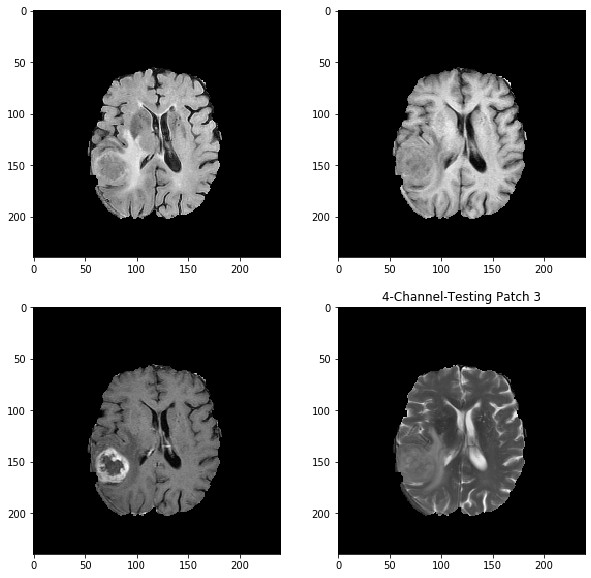

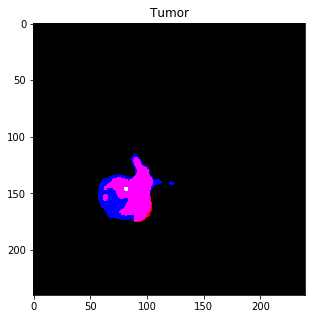

In [16]:
test_segmentation(3)    

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2390: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


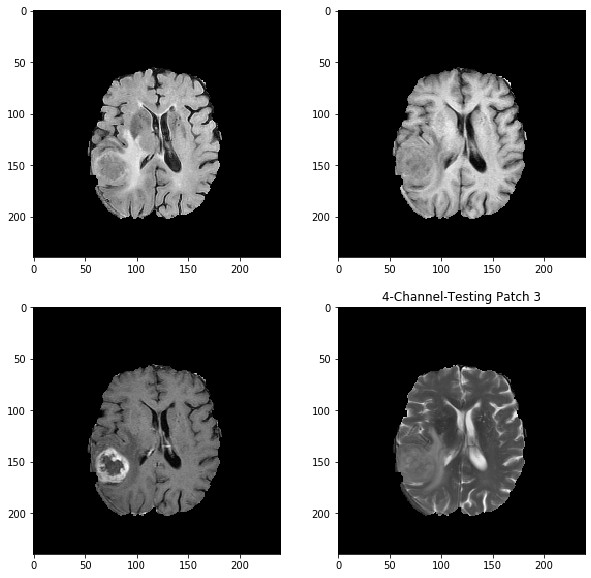

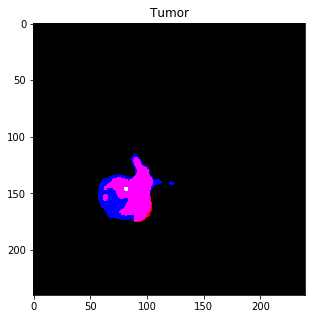

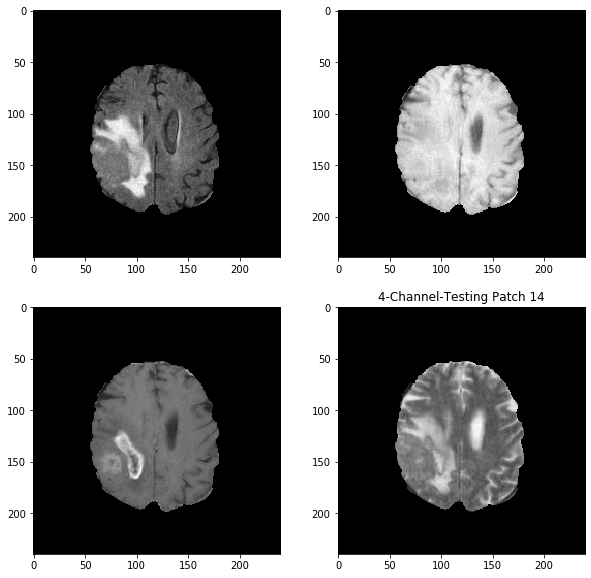

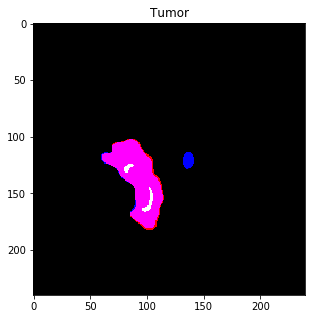

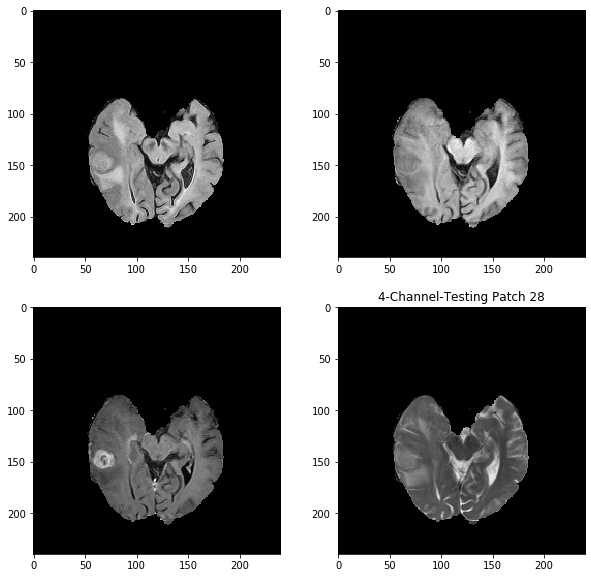

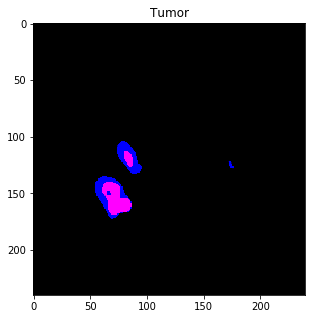

In [17]:
test_cases=[3,14,28]
for i in range(len(test_cases)):
    test_segmentation(test_cases[i])